# 1-D Parabolic Equations
Recall that the governing parabolic equation in 1D is:

$$\frac{\partial u}{\partial t}=\kappa\left(\frac{\partial^2 u}{\partial x^2}\right)$$

To solve the equation we need both boundary condition values at $u(x_0,t)$ and $u(x_1,t)$ and also initial conditions at $u(x,0)$.

We will need a class to store the 1D grid, set the initial conditions and update the boundary conditions.  Fortunately, the grid generation is simpler than  the 2D case.

To set up the initial conditions we will pass a function _f(x)_ (fun) to the function <code>initial_conditions()</code>. This will be called inside a loop passing the _x_ coordinate of every grid point.  A similar idea will be used for Dirichlet boundary conditions, where a function _f(t)_ will be passed as a parameter.  

Here is the code for the initial conditions functions:

    def initial_conditions(self,fun):
        for i in range(self.N_i):
            self.u[0,i] = fun(self.x[i])

Finally we need to know the time step that can be used.  As we saw in the lectures this is characterised by the CFL condition
$$\Delta t \le \nu \frac{\Delta x^2}{2\kappa}$$

The choice of the Courant number $\nu$ depends on the solver being used so we will pass it as a parameter in the <code>set_Delta_t()</code> function that calculates the time step.

    def set_Delta_t(self, Courant_number):
        self.Delta_t = Courant_number * self.Delta_x()**2/(2*self.kappa) 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def one(t):
    '''simple function of x and t which always returns 1.0'''
    return 1.0

class Grid:
    '''Class defining the grid for a 1D parabolic solver.  Solving
    
    $$\frac{\partial u}{\partial t}=\kappa\left(\frac{\partial^2 u}{\partial x^2}\right)$$

    The grid object contains the number of grid points (Ni), left
    and right coordinates (x0 and x1), flags for whether the boundaries
    are Dirichlet or Neumann boundary conditions and functions for
    plotting the solution both at a particular time level and in the
    form of an x-t plot.  The grid also contains the solution vector (u)
    which is stored as an array with different time levels, together with
    the number of time steps N_t and the (uniform) time step Delta_t.
    
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.
    '''
    
    DIRICHLET_BC = 0
    NEUMANN_BC = 1

    BC_NAME = ['left', 'right']
    
    def __init__(self,ni):
        # set up information about the grid
        self.x0 = 0.0 #  left
        self.x1 = 1.0 #  right
        self.N_i = ni # grid points in i direction
        self.N_t = 0 # how many time steps have we perform
        self.N_trec = 0 # how many time steps we record data at
        self.Delta_t = 0.0 # no dt value yet
        self.kappa = 1.0 # Thermal Diffusivity

        # initialise x, t and u arrays
        self.u = np.zeros((1,ni))
        self.x = np.zeros(ni)
        self.t = np.zeros(1)

        # boundary conditions (left and right )
        self.BC = [ self.DIRICHLET_BC, self.DIRICHLET_BC ]
        self.BC_fun = [ one, one ]

    def set_x0(self,x0):
        # set x origin
        self.x0 = x0
    
    def set_x1(self,x1):
        # set x extent
        self.x1 = x1
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from
        x0 to x1.  We are going to do this using linspace from
        numpy to create a list of x coordinates.'''
        self.x = np.linspace(self.x0, self.x1, self.N_i)
        if not Quiet:
            print(self)

    def initial_conditions(self,fun):
        '''set the initial conditions by calling the specified function
        fun(x) at every coordinate'''
        for i in range(self.N_i):
            self.u[0,i] = fun(self.x[i])

    def Delta_x(self):
        # calculate delta x
        return self.x[1]-self.x[0]
    
    def set_Neumann_bc(self,side):
        try:
             self.BC[self.BC_NAME.index(side)] = self.NEUMANN_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))
     
    def set_Dirichlet_bc(self,side,fun):
        '''set the Dirichlet boundary condition.  As well as the side
        this must be passed a function fun(t) which returns the value
        associated with the Dirichlet boundary at the time t.'''
        try:
            self.BC[self.BC_NAME.index(side)] = self.DIRICHLET_BC
        except:
            print('error {} must be one of {}'.format(side,self.BC_NAME))
        self.BC_fun[self.BC_NAME.index(side)] = fun

    def set_Delta_t(self,Courant_number):
        # set the time step using the Courant-Friedrichs-Lewy condition
        self.Delta_t = Courant_number * self.Delta_x()**2/(2*self.kappa) 
            
    def apply_BC(self,t):
        '''Apply the left and right boundary conditions to the values in
        the latest value of u at the current time level'''
        # left boundary
        if self.BC[0]==self.NEUMANN_BC:
            self.u[-1,0] = self.u[-1,2]
        else:
            self.u[-1,0] = self.BC_fun[0](t)
        
        # right
        if self.BC[1]==self.NEUMANN_BC:
            self.u[-1,-1] = self.u[-1,-3]
        else:
            self.u[-1,-1] = self.BC_fun[1](t)
    
    def integrate(self,t_stop,solver):
        '''call the integrator defined by solver to integrate
        the solution from t=0 to t=t_stop.'''
        
        # Set time to 0
        time = 0.0
        
        # When to report the progress
        o_time = t_stop/10
        print('Integrating to {:.3g} seconds Δt={:.3g} :'.format(t_stop,self.Delta_t),end='')
        
        # save the initial conditions as the first saved result for t = 0
        self.u = np.vstack([self.u, self.u])
        self.t = np.vstack([self.t, 0.0])

        # Loop over time window
        while True:
            # Check time step
            dt = min(self.Delta_t,t_stop-time)
            
            # Update the boundary conditions
            self.apply_BC(time)
            
            # Update the time 
            time += dt
            
            # Call the solver and save the time and results
            self.u[-1] = solver(self)
            self.t[-1] = time

            # Progress monitor
            if (time >= o_time) & (time<t_stop):
                print('#',end='')
                o_time += t_stop/10
                
                # Save time in time array
                self.t = np.vstack([self.t, time])
                
                # Save solution at current time step
                self.u = np.vstack([self.u, self.u[-1]])
                
                # Add 1 to the counter every time we record the solution 
                self.N_trec += 1 
 
            # Are we done?
            if time >= t_stop:
                print('. ')
                break
                
            self.N_t += 1 # Add 1 to the counter every time we perform a time step
        
    def plot(self,title):
        '''plot the solution at the current time level as points.  If there are
        more than 30 points in the x-direction then a line is used.'''
        if self.N_i<30:
            plt.plot(self.x,self.u[self.N_trec],'ob')
        else:
            plt.plot(self.x,self.u[self.N_trec],'-b')
        
        # Set figure title
        plt.title(title+', t={:.2f}s'.format(self.N_t*self.Delta_t))
        
        # Show plot
        plt.show()
        
    def report_BC(self):
        '''compile a string listing the boundary conditions on each side.
        We build up a string of two {side name}: {BC type} pairs and
        return it'''
        
        # initialise the string
        string = ''
        
        # loop over the sides
        for side in range(2):
            # add the side name
            string = string + self.BC_NAME[side]
            # and the bounday condition type
            if self.BC[side] == self.DIRICHLET_BC:
                string = string + ': Dirichlet, '
            elif self.BC[side] == self.NEUMANN_BC:
                string = string + ': Neumann, '
        return string[:-2] +'.' # lose the last comma and space.
    
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Parabolic problem, 𝜅={:.3g}\n'.format(self.kappa)
        describe += 'Uniform {} node grid from {} to {}.\n'.format(self.N_i, self.x0, self.x1)
        describe += 'Boundary conditions are - ' + self.report_BC()
        if self.N_t==0:
            describe += '\nInitial conditions at t=0.0, Δt={:.3g} seconds'.format(self.Delta_t)
        else:
            describe += '\n{} time steps from t=0.0 to t={:.3g}, Δt={:.3g} seconds'.format(self.N_t+1,self.N_t*self.Delta_t,self.Delta_t)
        return describe

### A test problem
We have a 1m long domain from _x_=0.0 to _x_=1.0 with 𝜅=1.0.  The initial conditions are
$$u(x,0)=\sin \frac{3\pi x}{2}$$
and we have a Dirichlet boundary condition with $u(0,t)=0.0$ at $x=0.0$ and a Neumann boundary condition $u'(1,t)=0.0$ at $x=1.0$.

This problem has an analytical solution 
$$u(x,t)=\exp\left(-\frac{9\kappa\pi^2 t}{4}\right)\sin\frac{3\pi x}{2}.$$

Let's set it up

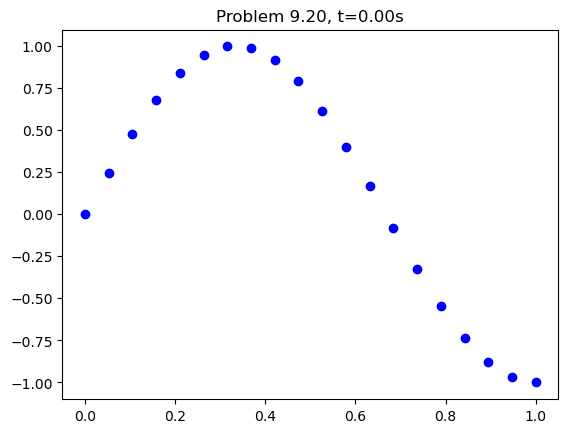

Parabolic problem, 𝜅=1
Uniform 20 node grid from 0.0 to 1.0.
Boundary conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=0.00132 seconds


In [2]:
def u_bc(x):
    # Function that defines the Dirichlet boundary condition
    return 0.0

def u_init(x):
    # Function that defines the initial condition
    return np.sin(3*np.pi*x/2)

# Generate a grid with 20 points
test = Grid(20)
test.generate()

# Set time step dt with Courant number ν = 0.95
test.set_Delta_t(0.95)

# Call the function to set the Neumann boundary condition at the right boundary
test.set_Neumann_bc('right')

# Call the function to set the Dirichlet boundary condition at the left boundary and pass as input 
# the function u_bc() with the value at the boundary
test.set_Dirichlet_bc('left',u_bc)

# Similarly, set initial conditions
test.initial_conditions(u_init)

# Plot initial solution array at t = 0
test.plot('Problem 9.20')

# Print description
print(test)

## The FTCS Scheme
Replacing the time derivities with the first order, forward, finite difference approximation and the second derivative with the 2nd order central finite difference approximation and introducing the index _n_ to represent the time level we obtain:
$$\frac{u_{i}^{n+1}-u_{i}^n}{\Delta t}=\kappa\frac{u^n_{i-1}-2u^n_i+u^n_{i+1}}{\Delta x^2}.$$
This can be re-arranged to obtain the explicit time-marching method:
$$u_i^{n+1}=u^n_i+\frac{\kappa\Delta t}{\Delta x^2}\left(u^n_{i-1}-2u^n_i+u^n_{i+1}\right).$$
This is the Forward-Time, Centred-Space (FTCS) scheme.  If is formally 1<sup>st</sup> order in time and 2<sup>nd</sup> order in space.





Integrating to 0.1 seconds Δt=0.00132 :#########. 


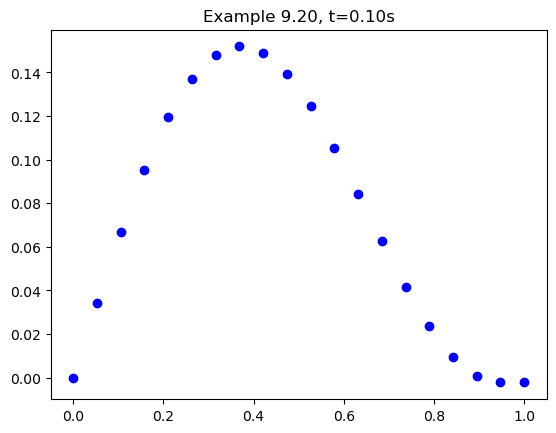

Parabolic problem, 𝜅=1
Uniform 20 node grid from 0.0 to 1.0.
Boundary conditions are - left: Dirichlet, right: Neumann.
76 time steps from t=0.0 to t=0.0987, Δt=0.00132 seconds


In [3]:
def FTCS(grid):
    '''perform one time step using the FTCS scheme on the parabolic 
    problem defined by grid. We are using whole array opperations
    for speed.'''
    
    # Calculate the Rx coefficient
    Rx = grid.kappa*grid.Delta_t/grid.Delta_x()**2
    
    # Create a copy of the solution array to be used in the update step
    u = grid.u[-1].copy()
    
    # Update step usign whole array operations
    u[1:-1]=u[1:-1]+Rx*(u[0:-2]-2*u[1:-1]+u[2:])
    return u

# Calculate solution for 0.1 seconds using the FTCS scheme
test.integrate(0.1, FTCS)

# Plot solution at t =0.1 s
test.plot('Example 9.20')

# Print description
print(test)


Integrating to 0.1 seconds Δt=0.00132 :#########. 


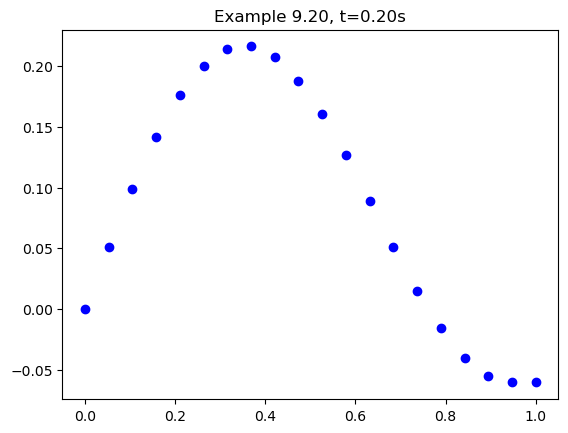

Parabolic problem, 𝜅=1
Uniform 20 node grid from 0.0 to 1.0.
Boundary conditions are - left: Dirichlet, right: Neumann.
151 time steps from t=0.0 to t=0.197, Δt=0.00132 seconds


In [4]:
# Do another 0.1 seconds
test.integrate(0.1, FTCS)

# Plot solution
test.plot('Example 9.20')

# Print description
print(test)

Integrating to 0.1 seconds Δt=1.19e-05 :#########. 


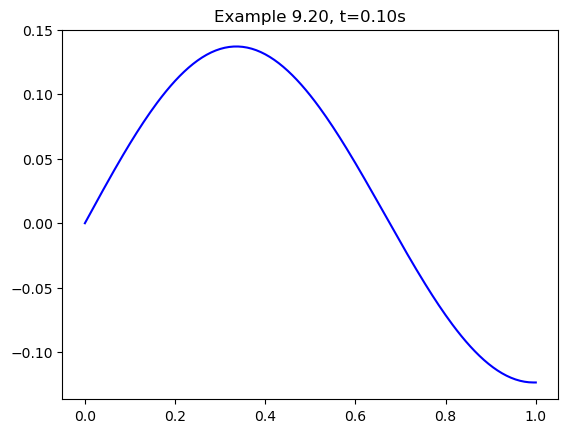

Parabolic problem, 𝜅=1
Uniform 201 node grid from 0.0 to 1.0.
Boundary conditions are - left: Dirichlet, right: Neumann.
8422 time steps from t=0.0 to t=0.1, Δt=1.19e-05 seconds


In [5]:
# Use more grid points - 201 in this case
test1 = Grid(201)

# Generate grid
test1.generate()

# Set time step dt with Courant number ν = 0.95 
test1.set_Delta_t(0.95)

# Similarly to above, set boundary and initial conditions
test1.set_Neumann_bc('right')
test1.set_Dirichlet_bc('left',u_bc)
test1.initial_conditions(u_init)

# Calculate solution for 0.1 seconds using the FTCS scheme
test1.integrate(0.1, FTCS)

# Plot solution
test1.plot('Example 9.20')

# Print description
print(test1)


### X-t plot
Because we have stored every time step, we can plot a contour plot of the solution with time on one axis and space on the other.  To do this we must:
1. create a <code>meshgrid</code> using _x_ and _t_
2. plot the contour plot
3. add a colour bar
4. add titles and captions


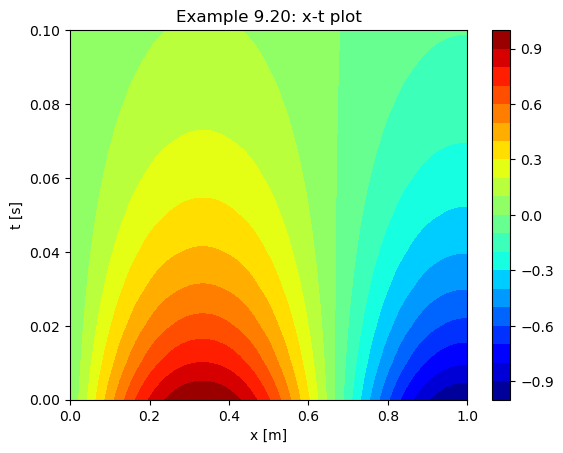

In [6]:
# Create mesh
X,T = np.meshgrid(test1.x,test1.t)

# Create figure and add plot to it
fig, ax1 = plt.subplots()

# Plot solution
cmap = plt.get_cmap('jet')
cf = ax1.contourf(X,T,test1.u,cmap=cmap, levels = 21)

# Add colobar
fig.colorbar(cf, ax=ax1)

# Set figure title
ax1.set_title('Example 9.20: x-t plot')

# Set plot x and y labels
ax1.set_xlabel('x [m]')
ax1.set_ylabel('t [s]')

# Show plot
plt.show()


### Analysis

The _x_-_t_ plot shows the expected behaviour with the amplitude of the oscilation decaying as time increases.

We can compare the solution with the analytical one as well


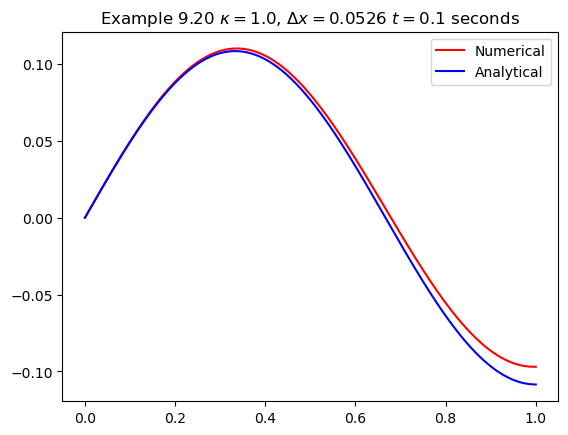

In [7]:
# Plot numerical solution
plt.plot(test1.x,test1.u[-1],'r-',label='Numerical')

# Calculate analytical
u_exact = np.exp(-9*test1.kappa*np.pi**2*test1.t[-1]/4)*np.sin(1.5*np.pi*test1.x)

# Plot analytical solution
plt.plot(test1.x,u_exact,'b-',label='Analytical')

# Set title and legend and show solution
plt.title('Example 9.20 $\kappa=1.0$, $\Delta x={:.3g}$ $t=0.1$ seconds'.format(test.Delta_x()))
plt.legend()
plt.show()

## Mesh refinement study
In this case we are going to use the range of _u(x)_ as the integrating quantity.

$$\text{Range}(u)=\max_i u - \min_i u$$

We will run the solution to _t_=0.1 seconds and use 𝜅=1.0  As with the Laplace Solvers I'm going to use a sequence of grids with

$$N_i = 20\times2^n + 1 \ n=1 \ldots 8.$$

The finest grid will have 5121 grid points and the coarsest 81.  The finest grid will take about 5 mins to run.  We are also going to plot the solution on every grid (together with the analytical solution).  

In [ ]:
import datetime # just seconds may not be enough

# We need to initial some lists
U_val = []
dx_val = []
run_time = []
n_pts =[]

# Start the loop to calculate solution for different grid sizes
for grid_index in range(8,1,-1):
    
    # Set number of points
    ni = 20 * 2**grid_index + 1
    n_pts.append(ni)
    
    # Set up the problem similarly as before
    test = Grid(ni)
    test.generate()
    test.set_Delta_t(0.95)
    test.set_Neumann_bc('right')
    test.set_Dirichlet_bc('left',u_bc)
    test.initial_conditions(u_init)
    print(test)
    
    # Record starting time
    start = time.process_time()
    
    # Call the solver for 0.1 s
    test.integrate(0.1, FTCS)
    
    # Record end time and total solving time
    stop = time.process_time()
    elapsed = datetime.timedelta(seconds=stop-start)
    print("The solver took ",elapsed)

    # Save dx and the range into the list for evalutation
    dx_val.append(test.Delta_x())
    U_val.append(np.max(test.u[-1])-np.min(test.u[-1]))
    print('Range(u) is ',U_val[-1],'\n') 
    
    # Save run time into list
    run_time.append(stop-start)
        
    # Plot a graph of the numerical solution and the analytical solution on the same grid.
    plt.plot(test.x,test.u[-1],'r-',label='Numerical')
    u_exact = np.exp(-9*test.kappa*np.pi**2*test.t[-1]/4)*np.sin(1.5*np.pi*test.x)
    plt.plot(test.x,u_exact,'b-',label='Analytical')
    plt.title('Example 9.20 $\kappa=1.0$, $\Delta x={:.3g}$ $t=0.1$ seconds'.format(test.Delta_x()))
    plt.legend()
    plt.show()


In [ ]:
# Now run the mesh refinement analysis
from refinement_analysis import refinement_analysis

# This can be done using the refinement analysis() function
# We give as arguments dx and the range
analysis = refinement_analysis(dx_val,U_val)
analysis.report('range(u)')
analysis.plot(True,'range(u)')

### Analysis
The method has an apparent accuracy of first order.  We expect this since it's 2nd order in space and 1st order in time.  We've taken a lot of time steps so accuracy is at most 1st order.  On the finest grids (_Ni_>320) the solution is grid converged (and it's pretty close on the other grids).  So what about the execution time:

In [ ]:
# Plot the runtime
plt.plot(n_pts,run_time,'o')
plt.title('Runtime')
plt.xlabel('N')
plt.yscale('log',base=10) 
plt.ylabel('runtime (s)')
plt.show()